In [ ]:
# import libraries
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler # veri normalizasyonu

from sklearn.model_selection import (train_test_split, # veri setini eğitim ve test olarak ayırmak
                                     KFold, # çapraz doğrulama ile performans değerlendirmesi
                                     cross_val_score, # KFold ile yapılan süreci basitleştirir 
                                     GridSearchCV)  # modelin hiperparametrelerini optimize etme

from sklearn.metrics import (classification_report, # modelin sınıflandırma başarısını değerlendirme
                             confusion_matrix, # model sınıflandırma başarısının görsel analizi
                             accuracy_score) # modelin doğruluğunun hesaplanması

from sklearn.linear_model import LogisticRegression # ikili sınıfandırma
from sklearn.tree import DecisionTreeClassifier # karar ağacı ile sınıflandırma
from sklearn.neighbors import KNeighborsClassifier # en yakın komşuyla sınıflandırma
from sklearn.naive_bayes import GaussianNB # Naives Bayes ile sınıflandırma
from sklearn.svm import SVC # SVM ile sınıflandırma

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import data and EDA
os.chdir('res')

In [ ]:
# loading data
df = pd.read_csv("diabetes.csv")
df_name = df.columns

In [ ]:
# column names -> upper_case & lower_case - spaces - eng chars
# num_sample and lost data
# data types
df.info()

In [ ]:
df.describe()

In [ ]:
sns.pairplot(df, hue='Outcome')

In [ ]:
# if abs(correlation) >= .8 
def plot_correlation_heatmap(dataframe = df):
    corr_matrix = dataframe.corr() # correlation of each column
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt = ".2f", linewidths=.5, cmap="coolwarm")
    plt.title("Correlation of Features")
    plt.show()
    
plot_correlation_heatmap()    

In [ ]:
#  outlier detection
def detect_outliers_iqr(dataframe = df):
    outlier_indices = list()
    outliers_df = pd.DataFrame()
    
    for col in df.select_dtypes(include=['float64','int64']).columns:
        
        Q1 = df[col].quantile(0.25) # first quartile
        Q3 = df[col].quantile(0.75) # third quartile
        
        IQR = Q3 - Q1 # Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_in_col = df[ (df[col] > upper_bound) | (df[col] < lower_bound) ]
        outlier_indices.extend(outliers_in_col.index)
        
        outliers_df = pd.concat([outliers_df, outliers_in_col], axis=0)
        
    # remove duplicate indices
    outlier_indices = list(set(outlier_indices))
    
    # remove duplicate rows in the outliers dataframe
    outliers_df = outliers_df.drop_duplicates()
    
    return outliers_df , outlier_indices
        

outliers_df , outlier_indices = detect_outliers_iqr()    

In [ ]:
# remove outliers from the dataframe
cleaned_df = df.drop(outlier_indices).reset_index(drop=True)
cleaned_df.describe()


In [ ]:
# train test split
X = cleaned_df.drop(['Outcome'],axis=1) # drop outcome column -> axis = 1
y = cleaned_df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# normalization - standardization

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # features
X_test_scaled = scaler.transform(X_test) # X_train -> X_test : scaler has been learned.
X_train_scaled


In [12]:
# model training and evaluation

def getBasedModel():
    basedModels = {'LR' : LogisticRegression(),
                   'DT' : DecisionTreeClassifier(),
                   'KNN' : KNeighborsClassifier(),
                   'NB' : GaussianNB(),
                   'SVM' : SVC(),
                   'AdaB' : AdaBoostClassifier(),
                   'GBM' : GradientBoostingClassifier(),
                   'RF' : RandomForestClassifier()}
    return basedModels
    

In [37]:
def baseModelsTraining(models,X_train = X_train, y_train = y_train):
    results = list()
    
    for name, model in models.items():
        kfold = KFold(n_splits=10)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        
        print(f"{name}, accuracy : {cv_results.mean()}, std : {cv_results.std()} ")
    return results

In [46]:
results = baseModelsTraining(getBasedModel())
names = list(getBasedModel().keys())


LR, accuracy : 0.782845744680851, std : 0.06205751329302423 
DT, accuracy : 0.6806737588652483, std : 0.05701505735110916 
KNN, accuracy : 0.7287677304964539, std : 0.04863639115379103 
NB, accuracy : 0.7597960992907802, std : 0.07571110136433304 
SVM, accuracy : 0.7598847517730496, std : 0.056216806652984494 
AdaB, accuracy : 0.7223847517730497, std : 0.06830501169113913 
GBM, accuracy : 0.7411347517730497, std : 0.05677013140310828 
RF, accuracy : 0.7661790780141844, std : 0.060220832505851356 


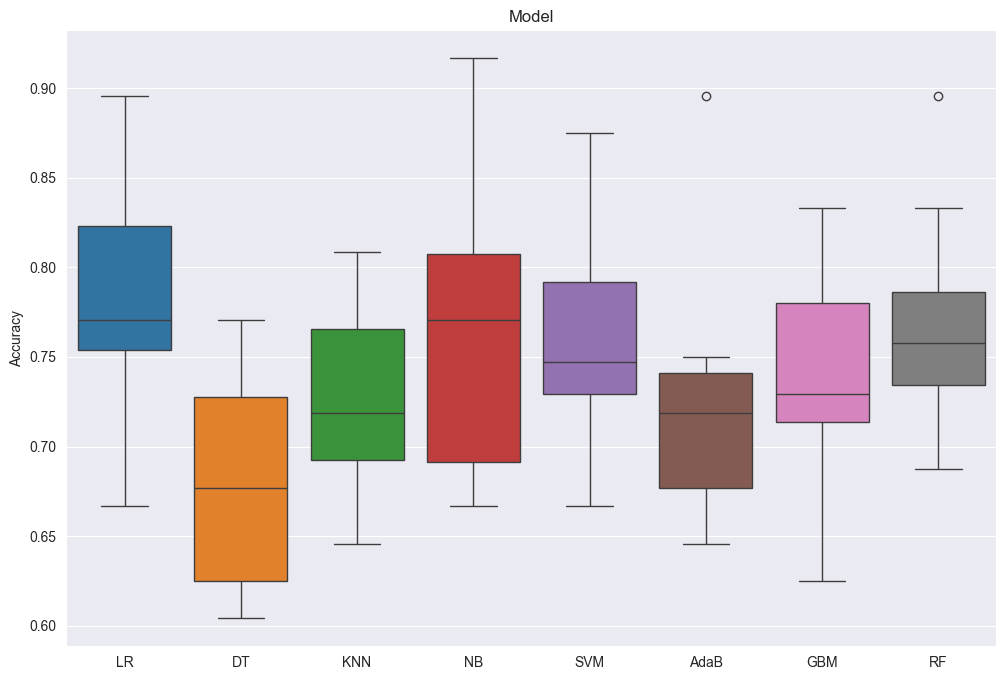

In [47]:
def plot_box(names = names,results = results):
    df = pd.DataFrame({names[i] : results[i] for i in range (len(names))})
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df)
    plt.title("Model")
    plt.ylabel("Accuracy")
    plt.show()
    
plot_box()    